# Pipeline for High-z Radio Galaxies 22: Redshift prediction (high z, new instance)

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done only with AGN from the Million Quasar Catalog (MQC).  
Only sources with confirmed $z$ will be used.

Also, as a test, only high-redshift sources ($z \geq 3$, from distribution, mostly AGN) will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [6]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [7]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [8]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [9]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [10]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methdods for PyCaret and saved models.

In [11]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [12]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [13]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [14]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

Method to compare and plot redshifts.

In [15]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])
    min_for_range = np.nanmin([np.nanmin(1 + true_z.loc[filt_pair_z]), np.nanmin(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=np.floor(min_for_range), right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=np.floor(min_for_range), top=np.ceil(max_for_range))
    ax_pre.set_title(title, fontsize=14)
    plt.tight_layout()

***

## Reading data

In [16]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [17]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [18]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [19]:
mqc_version = '7_4d'  # '7_2'

In [20]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [21]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [22]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [23]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [24]:
# full_catalog_df.describe()

Combine redshift values (AGN + galaxies).

In [25]:
idx_non_Z                = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

#### Select only confirmed radio AGN

In [26]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]
filter_confirmed = full_catalog_df.loc[:, 'is_AGN'] == 1
filter_redshift  = (full_catalog_df.loc[:, 'Z'] > 0) | (full_catalog_df.loc[:, 'zsp'] > 0)
filter_radio     = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df  = full_catalog_df.loc[filter_confirmed & filter_redshift & filter_radio]

#### Select high-redshift sources

In [27]:
redshift_low_lim = 3.0
filter_high_z    = full_catalog_df.loc[:, 'Z'] >= redshift_low_lim
full_catalog_df  = full_catalog_df.loc[filter_high_z]

In [28]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections.')

In this dataset, with 313 elements,
313 of them are marked as AGN, 0 have been indentified as galaxies, and 313 are identified as radio detections.


---

## Possible correlations

In [29]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [30]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [31]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [32]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'radio_detect', 'zsp'])

---

#### Add prediction from first AGN/galaxy model as feature.

In [33]:
# AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

In [34]:
# AGN_pred_threshold = 0.5
# full_catalog_df    = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=AGN_pred_threshold, raw_score=False).drop(columns=['Score'])

In [35]:
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'class'})

---

## Split data: Test, Train, Validation

In [36]:
# train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
#                                                 random_state=seed, stratify=None)
train_test_df = full_catalog_df.loc[np.isfinite(full_catalog_df.loc[:, 'Z'])].sample(frac=0.8, random_state=seed)  # Train + test sets
validation_df = full_catalog_df.drop(train_test_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (313, 39)
Data for Modeling (Train and Test): (250, 39)
Unseen Data For Validation: (63, 39)
----------------------------------------


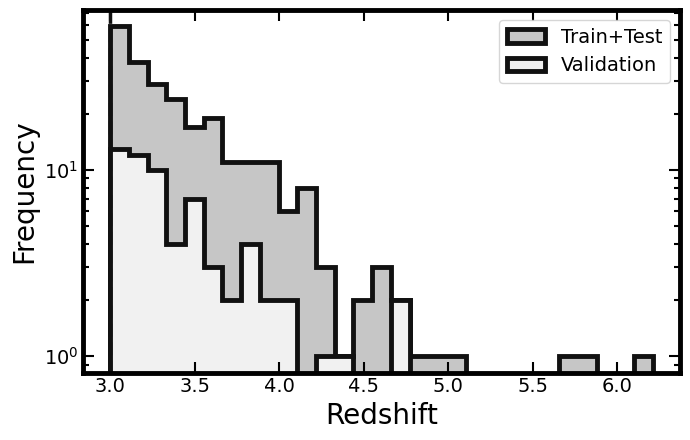

In [37]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=redshift_low_lim, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [38]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [39]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [40]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [41]:
rsd_vals

z_y         493.597243
i_z         298.865815
w1_w2       234.114539
r_i         165.828641
g_r          86.124744
g_i          83.065746
w2_w3        22.640096
band_num     18.663249
J_H          17.441672
w3_w4        14.756636
Z            14.363218
H_K           7.136386
gmag          5.519823
g/J           5.399373
ymag          5.300025
rmag          5.170471
r/H           5.076218
imag          5.061295
i/K           5.049786
zmag          4.926331
W1mproPM      4.467522
w1/w4         4.335338
W2mproPM      4.012659
w2/w4         3.841117
w1/w3         3.632709
y/W2          3.013542
z/W1          2.666909
r/z           2.102662
i/y           2.098155
W3mag         2.024642
W4mag         0.668098
Jmag          0.434163
J/K           0.390808
Hmag          0.309555
FUV/K         0.063755
Kmag          0.063185
NUVmag        0.052556
FUVmag        0.000000
FUV_NUV      -1.104403
dtype: float64

In [42]:
correlation = norm_train_test_df.corr()

In [43]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [44]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [45]:
target_feat = 'Z'

In [46]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [47]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [48]:
list_drop_corr

['Kmag',
 'i/K',
 'r/H',
 'g/J',
 'J/K',
 'w1/w4',
 'Hmag',
 'w2/w4',
 'W2mproPM',
 'W3mag',
 'zmag',
 'w1/w3',
 'imag',
 'W1mproPM',
 'Jmag',
 'rmag',
 'g_i',
 'i/y',
 'ymag',
 'r/z']

In [49]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [50]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [51]:
corr_discard = norm_train_test_discard.corr()

In [52]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
W4mag     FUV_NUV     0.724476
FUV/K     H_K         0.653517
g_r       Z           0.624214
y/W2      z/W1        0.615683
band_num  gmag        0.550559
w2_w3     gmag        0.524854
          band_num    0.521617
w3_w4     H_K         0.504624
y/W2      band_num    0.482593
gmag      y/W2        0.474447
          Z           0.464332
r_i       Z           0.445444
g_r       w1_w2       0.445284
FUV/K     J_H         0.439677
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

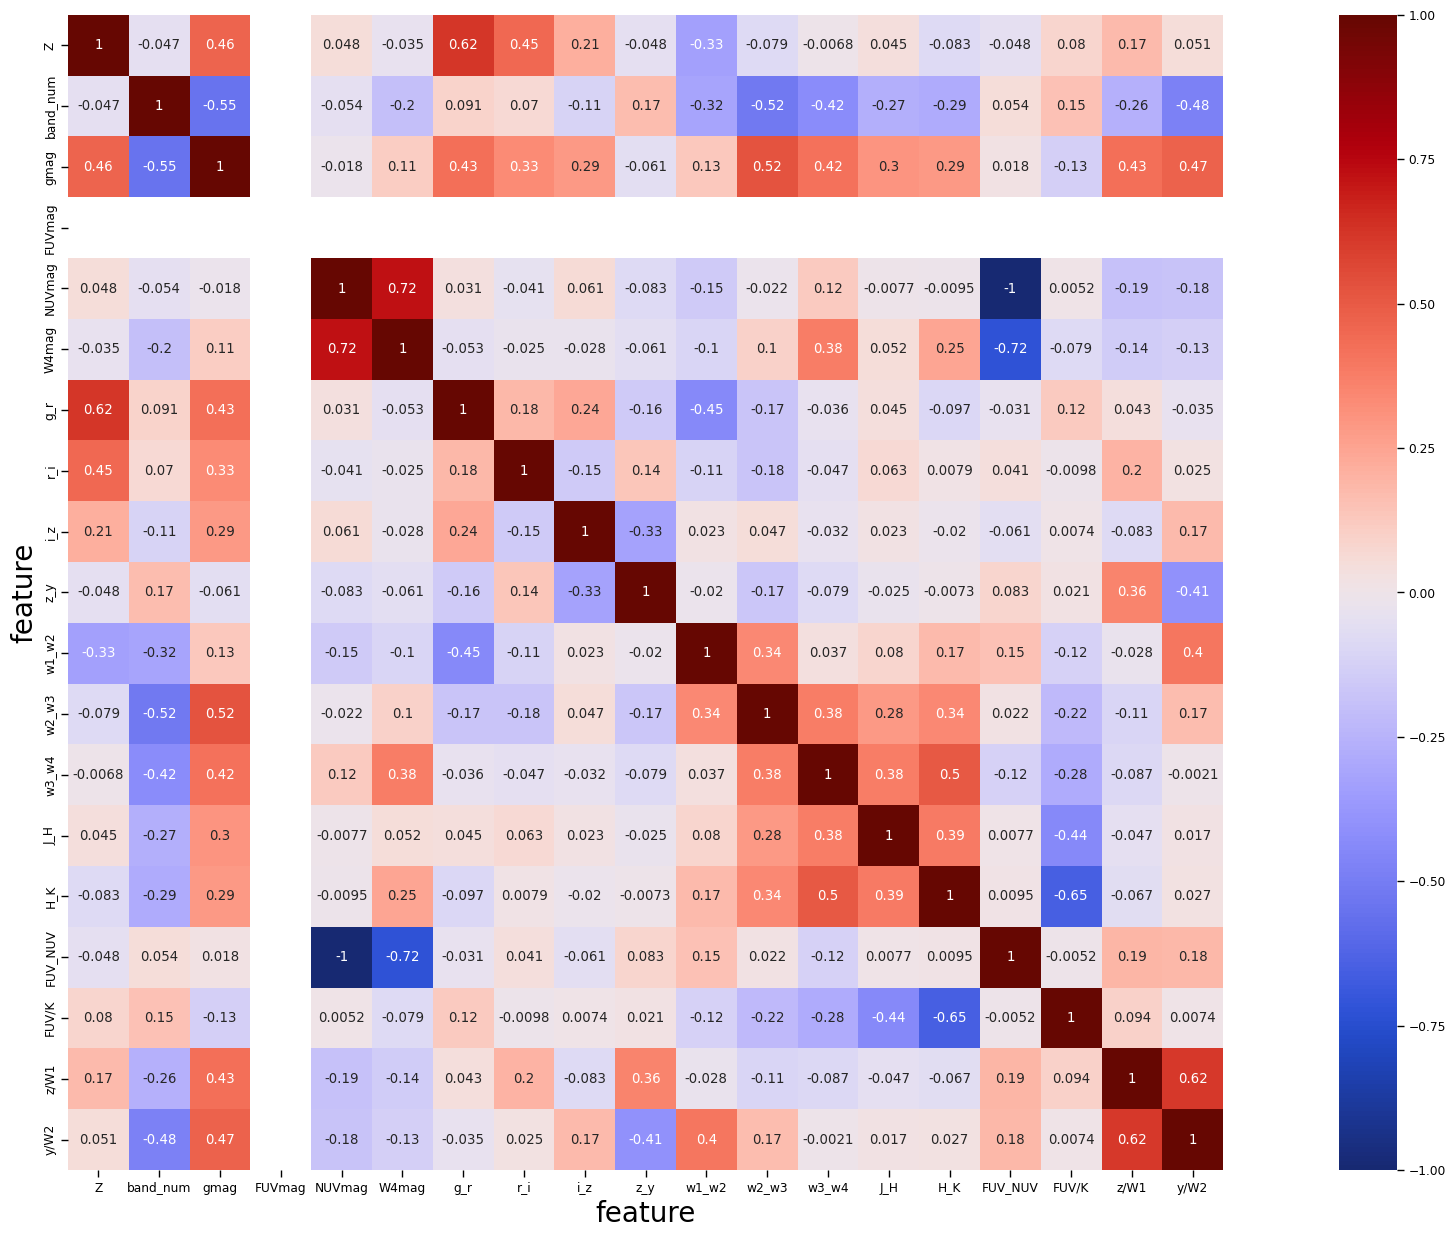

In [53]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [54]:
# norm_train_test_discard.loc[:, 'Z'] = norm_train_test_discard.loc[:, 'Z'].astype(bool)

In [55]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [56]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y    
FUV/K     FUV/K    1.000000
band_num  y/W2     0.389429
Z         g_r      0.290062
band_num  gmag     0.271759
          w2_w3    0.247373
g_r       Z        0.192634
w3_w4     w2_w3    0.177837
w2_w3     H_K      0.129685
y/W2      z/W1     0.127687
band_num  z_y      0.118453
z_y       y/W2     0.079556
band_num  w1_w2    0.075516
y/W2      w2_w3    0.074541
J_H       w2_w3    0.053759
          gmag     0.049389
H_K       w2_w3    0.036012
gmag      w2_w3    0.027469
w1_w2     w2_w3    0.021068
band_num  Z        0.019235
          z/W1     0.018712
dtype: float64

In [57]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [58]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [59]:
target_feat = 'Z'

In [60]:
list_drop_pps = []

In [61]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [62]:
list_drop_pps

[]

In [63]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [64]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'Z', random_seed=seed)

In [65]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,g_r,Z,0.192634,regression,True,mean absolute error,0.107607,0.086879,DecisionTreeRegressor()
1,band_num,Z,0.019235,regression,True,mean absolute error,0.107607,0.105538,DecisionTreeRegressor()
2,gmag,Z,0.000000,regression,True,mean absolute error,0.107607,0.123380,DecisionTreeRegressor()
3,FUVmag,Z,0.000000,regression,True,mean absolute error,0.107607,0.114374,DecisionTreeRegressor()
4,NUVmag,Z,0.000000,regression,True,mean absolute error,0.107607,0.114448,DecisionTreeRegressor()
5,W4mag,Z,0.000000,regression,True,mean absolute error,0.107607,0.120259,DecisionTreeRegressor()
6,r_i,Z,0.000000,regression,True,mean absolute error,0.107607,0.134566,DecisionTreeRegressor()
7,i_z,Z,0.000000,regression,True,mean absolute error,0.107607,0.137728,DecisionTreeRegressor()
8,z_y,Z,0.000000,regression,True,mean absolute error,0.107607,0.151912,DecisionTreeRegressor()
9,w1_w2,Z,0.000000,regression,True,mean absolute error,0.107607,0.128128,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [66]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
# z >= 3
final_feats.remove('band_num')  # After Boruta
final_feats.remove('FUVmag')  # After Boruta
final_feats.remove('NUVmag')  # After Boruta
final_feats.remove('W4mag')  # After Boruta
final_feats.remove('w2_w3')  # After Boruta
final_feats.remove('w3_w4')  # After Boruta
final_feats.remove('J_H')  # After Boruta
final_feats.remove('H_K')  # After Boruta
final_feats.remove('FUV_NUV')  # After Boruta
final_feats.remove('FUV/K')  # After Boruta
# # z >= 4
# final_feats.remove('g_r')  # After Boruta
# final_feats.remove('band_num')  # After Boruta
# final_feats.remove('FUVmag')  # After Boruta
# final_feats.remove('NUVmag')  # After Boruta
# final_feats.remove('Jmag')  # After Boruta
# final_feats.remove('Hmag')  # After Boruta
# final_feats.remove('Kmag')  # After Boruta
# final_feats.remove('w1_w2')  # After Boruta
# final_feats.remove('w2_w3')  # After Boruta
# final_feats.remove('w3_w4')  # After Boruta
# final_feats.remove('J_H')  # After Boruta
# final_feats.remove('H_K')  # After Boruta
# final_feats.remove('FUV_NUV')  # After Boruta
# final_feats.remove('J/K')  # After Boruta
# final_feats.remove('FUV/K')  # After Boruta
# final_feats.remove('y/W2')  # After Boruta

In [67]:
# z >= 3
feats_2_discard = list_drop_corr + list_drop_pps + ['band_num', 'FUVmag', 'NUVmag', 'W4mag', 'w2_w3',\
                                                    'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'FUV/K']
# z >= 4
# feats_2_discard = list_drop_corr + list_drop_pps + ['g_r', 'band_num', 'FUVmag', 'NUVmag', 'Jmag',\
#                                                     'Hmag', 'Kmag', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H',\
#                                                     'H_K', 'FUV_NUV', 'J/K', 'FUV/K', 'y/W2']

Boruta discards one feature.

In [68]:
exp_radio = pyr.setup(data=train_test_df, target='Z', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(250, 39)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(174, 8)"


In [69]:
pyr.get_config('X').columns

Index(['gmag', 'g_r', 'r_i', 'i_z', 'z_y', 'w1_w2', 'z/W1', 'y/W2'], dtype='object')

In [70]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [71]:
pyr.add_metric('s_mad',  'sigma_mad',    sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7fb30aca9160>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [72]:
# z >= 3
final_selection_reg  = ['rf', 'et', 'gbr', 'catboost', 'xgboost', 'dummy']
# z >= 4
# final_selection_reg  = ['ada', 'catboost', 'rf', 'et', 'dt', 'dummy']
n_models             = 5
# top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort='s_mad')  # 1:15 hour for used_models_clf
top_model_z          = pyr.compare_models(n_select=n_models, exclude=['knn'], sort='s_mad')  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.1768,0.1079,0.2934,0.5249,0.0593,0.0478,0.1570,0.0373,0.2934,0.0577,0.0343,0.0340
et,Extra Trees Regressor,0.1725,0.0883,0.2690,0.6015,0.0546,0.0471,0.1605,0.0368,0.2690,0.0535,0.0284,0.0300
gbr,Gradient Boosting Regressor,0.1903,0.1272,0.3182,0.4272,0.0641,0.0517,0.1615,0.0375,0.3182,0.0626,0.0513,0.0150
catboost,CatBoost Regressor,0.1668,0.0953,0.2728,0.5929,0.0552,0.0450,0.1622,0.0366,0.2728,0.0529,0.0284,0.1790
xgboost,Extreme Gradient Boosting,0.1908,0.1267,0.3223,0.3653,0.0645,0.0513,0.1688,0.0386,0.3223,0.0630,0.0346,4.3620
lightgbm,Light Gradient Boosting Machine,0.1868,0.1111,0.2948,0.5341,0.0609,0.0515,0.1736,0.0388,0.2948,0.0596,0.0284,4.2340
dt,Decision Tree Regressor,0.2347,0.1963,0.3994,-0.0381,0.0796,0.0646,0.1866,0.0431,0.3994,0.0817,0.0458,0.0090
omp,Orthogonal Matching Pursuit,0.2184,0.1590,0.3540,0.2102,0.0785,0.0598,0.1925,0.0444,0.3540,0.0705,0.0395,0.0090
huber,Huber Regressor,0.2078,0.1601,0.3527,0.2349,0.0777,0.0561,0.2033,0.0454,0.3527,0.0695,0.0340,0.0090
ada,AdaBoost Regressor,0.1894,0.1067,0.2947,0.5256,0.0593,0.0513,0.2050,0.0471,0.2947,0.0576,0.0343,0.0170


Thus, we select `lightgbm` as meta learner.

Thus, we stack the models.

In [73]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0], optimize='s_mad')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2239,0.1380,0.3715,0.3945,0.0781,0.0643,0.1479,0.0360,0.3715,0.0823,0.1111
1,0.1802,0.1622,0.4027,0.5476,0.0717,0.0437,0.1142,0.0276,0.4027,0.0647,0.0556
2,0.1765,0.0577,0.2402,0.7688,0.0486,0.0457,0.1813,0.0378,0.2402,0.0477,0.0000
3,0.1357,0.0295,0.1717,0.7978,0.0371,0.0386,0.1564,0.0340,0.1717,0.0376,0.0000
4,0.1610,0.0587,0.2424,0.7010,0.0483,0.0437,0.1741,0.0388,0.2424,0.0507,0.0588
5,0.1972,0.0933,0.3055,-0.2768,0.0661,0.0588,0.1913,0.0414,0.3055,0.0718,0.0588
6,0.2386,0.2806,0.5297,0.4137,0.0945,0.0518,0.1270,0.0298,0.5297,0.0810,0.0588
7,0.1733,0.0655,0.2559,0.4538,0.0528,0.0484,0.1785,0.0387,0.2559,0.0542,0.0588
8,0.1460,0.0289,0.1701,0.6347,0.0389,0.0438,0.1569,0.0347,0.1701,0.0391,0.0000


In [74]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping='asha', optimize='s_mad') # ,\
#                                search_library='tune-sklearn', search_algorithm='random')  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2337,0.1419,0.3767,0.3774,0.0807,0.0696,0.1920,0.0451,0.3767,0.0887,0.1111
1,0.1905,0.2024,0.4499,0.4353,0.0809,0.0456,0.0976,0.0229,0.4499,0.0713,0.0556
2,0.1889,0.0642,0.2533,0.7429,0.0507,0.0487,0.2118,0.0445,0.2533,0.0499,0.0000
3,0.1220,0.0217,0.1471,0.8516,0.0320,0.0351,0.1748,0.0402,0.1471,0.0326,0.0000
4,0.1338,0.0384,0.1961,0.8043,0.0412,0.0377,0.1338,0.0286,0.1961,0.0429,0.0000
5,0.1867,0.0617,0.2485,0.1552,0.0553,0.0555,0.2273,0.0474,0.2485,0.0578,0.0588
6,0.2509,0.3149,0.5611,0.3422,0.1009,0.0539,0.0780,0.0183,0.5611,0.0856,0.0588
7,0.1625,0.0539,0.2322,0.5504,0.0504,0.0467,0.1249,0.0285,0.2322,0.0505,0.0000
8,0.1467,0.0285,0.1688,0.6403,0.0385,0.0443,0.2174,0.0480,0.1688,0.0392,0.0000


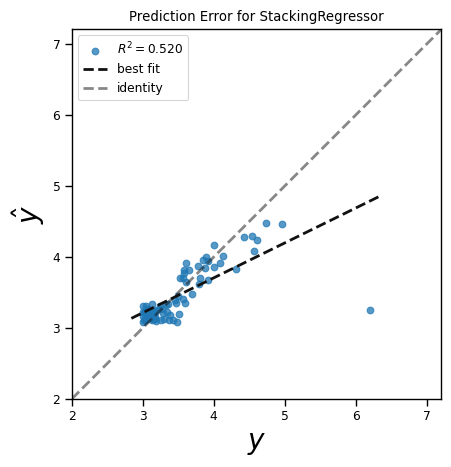

In [75]:
pyr.plot_model(tuned_z_reg, plot='error')

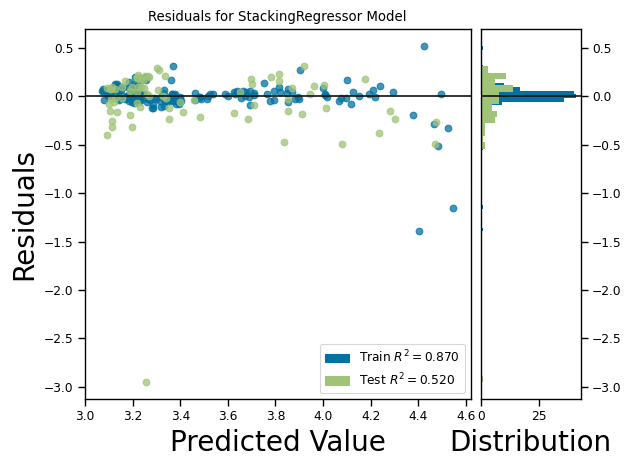

In [76]:
pyr.plot_model(tuned_z_reg, plot='residuals')

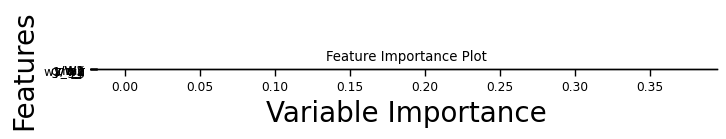

In [77]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [78]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mse
max_depth,8
max_features,log2
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None
min_samples_leaf,4


In [79]:
plt.rcParams.update(plt.rcParamsDefault)

In [80]:
pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1946,0.1517,0.3895,0.5197,0.0732,0.0500,0.2227,0.0477,0.3895,0.0623,0.0132


,gmag,g_r,r_i,i_z,z_y,w1_w2,z/W1,y/W2,Z,Label
0,0.145707,-1.216709,-0.112466,0.081092,-1.619686,0.662313,2.565910,3.672304,3.052,3.265435
1,0.676507,1.385402,1.349523,0.202420,-0.287432,-1.485974,-0.682405,-1.133964,4.540,4.302738
2,-0.430561,-0.630048,-0.036323,-0.380768,0.499072,0.130107,0.165874,-0.211047,3.000,3.090693
3,2.109874,2.138319,0.499415,-0.472826,-1.293702,0.954218,0.166642,1.289929,3.998,4.175655
4,0.838499,0.611609,0.142945,0.857901,0.696751,0.954218,-1.245824,-1.153095,3.519,3.699185
...,...,...,...,...,...,...,...,...,...,...
71,2.109874,-1.015087,-0.258827,7.795791,0.161367,-1.078161,1.769000,1.289929,3.590,3.353488
72,-1.830906,1.204158,-0.591592,-0.615556,0.139700,-1.579752,1.038215,0.019179,3.880,3.851324
73,-2.671534,-0.170635,-0.260225,-0.087632,-0.008116,-1.180622,0.776048,0.093803,3.491,3.455638
74,-0.600869,0.875738,0.320710,0.195583,-0.060346,-1.167050,1.483559,0.987668,3.584,3.781724


In [81]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1946,0.1517,0.3895,0.5197,0.0732,0.0500,0.2227,0.0477,0.3895,0.0623,0.0132


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [82]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/s

In [83]:
if save_model_flag:
    pyr.save_model(final_z_reg, 'models/regression_z_may_30_2022')  # Model (it will be saved with .pkl extension)
    # pyr.save_config('models/config_regression_z_may_30_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [84]:
if load_model_flag:
    final_z_reg = pyr.load_model('models/regression_z_may_30_2022')

### Prediction process

#### Feature importances

In [85]:
estimators_list = get_base_estimators_names(final_z_reg)

In [86]:
extended_data_z = validation_df.loc[:, get_final_column_names(final_z_reg, validation_df)].copy()
extended_idx_z  = extended_data_z.index
initial_cols_z  = extended_data_z.columns
extended_cols_z = extended_data_z.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_z = extended_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [87]:
print('Running data pre-processing:\n')
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_z_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_z = method.transform(extended_data_z)
extended_data_z_df = pd.DataFrame(extended_data_z, columns=extended_cols_z, index=extended_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [88]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    if hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)
else:
    if hasattr(final_z_reg.final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.final_estimator_.feature_importances_
    elif hasattr(final_z_reg.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_z, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_z))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [89]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_z_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_z_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_z_reg.estimators
    estimators_list_ = final_z_reg.estimators_

In [90]:
base_models_names = [model[0] for model in estimators_list]

In [91]:
coef_sorted_base_df = {}

In [92]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_z.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [93]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [94]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for gbr...
Calculating for catboost...
Calculating for xgboost...


et                gbr            catboost            xgboost           
  Feature Importance Feature Importance  Feature Importance Feature Importance
0     g_r  33.149782     g_r  45.533258      g_r  33.095335     g_r  27.073193
1    gmag  23.502633    gmag  18.038918     gmag  20.058101    gmag  20.837795
2   w1_w2  15.849423     r_i  14.281020      r_i  11.580046     r_i  17.703447
3     r_i  10.875135    z/W1  11.571941    w1_w2  10.722795   w1_w2  13.796419
4    z/W1   4.705236   w1_w2   3.650925     z/W1   9.294884     i_z   8.448837
5     i_z   4.380233     z_y   2.560061      i_z   6.156906    z/W1   6.474439
6     z_y   3.837783    y/W2   2.535712      z_y   5.328214    y/W2   3.818483
7    y/W2   3.699775     i_z   1.828165     y/W2   3.763719     z_y   1.847384

In [95]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,xgboost,26.577706
1,catboost,20.970248
2,gbr,17.364207
3,et,7.564792
4,g_r,7.382558
5,r_i,5.708100
6,gmag,5.053740
7,i_z,2.991287
8,z_y,2.267543
9,w1_w2,2.229040


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
g_r	33.158
gmag	20.080
r_i	11.659
w1_w2	10.734
z/W1	9.245
i_z	6.120
z_y	5.253
y/W2	3.752


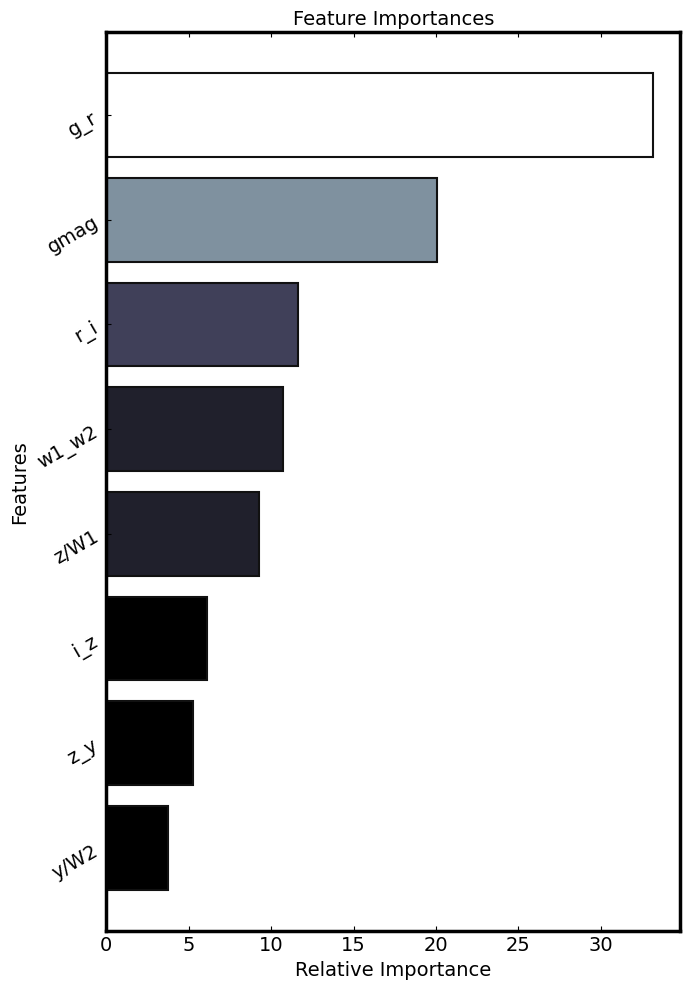

In [96]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_regression_z_06.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [97]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1098,0.0265,0.1629,0.8320,0.0357,0.0321,0.1337,0.0285,0.1629,0.0370,0.0159


In [98]:
validation_prediction_reg.loc[:, ['Z', 'Label']].describe()

,Z,Label
count,63.000000,63.000000
mean,3.423730,3.427248
std,0.400536,0.379241
min,3.003000,3.114409
25%,3.127000,3.151132
50%,3.297000,3.208389
75%,3.574500,3.687278
max,4.700000,4.590307


In [99]:
# clb.vmax

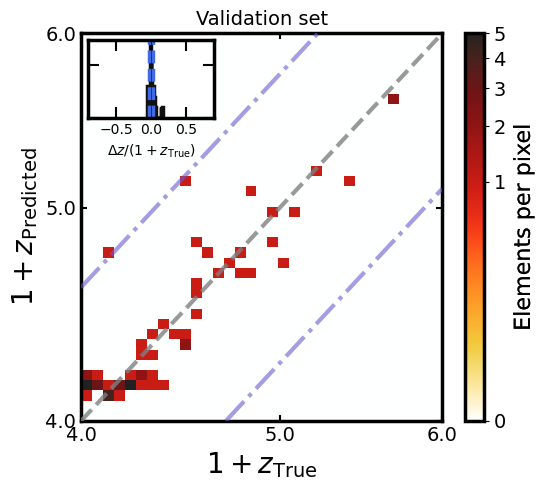

In [100]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/compare_plot_validation_redshift_06.pdf', bbox_inches='tight')
plt.show()

In [101]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns  = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['Z']), train_test_df.loc[:, 'Z'], False, 'Z'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['Z']),
                train_test_df.loc[:, 'Z'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_df        = pd.concat([X_train, y_train], axis=1)
test_df         = pd.concat([X_test, y_test], axis=1)

In [102]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0777,0.0231,0.1519,0.8940,0.0282,0.0212,0.0739,0.0171,0.1519,0.0274,0.0115


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1014,0.0521,0.2284,0.8349,0.0393,0.0262,0.0944,0.0215,0.2284,0.0360,0.0132


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0849,0.0319,0.1786,0.8716,0.0320,0.0227,0.0760,0.0173,0.1786,0.0303,0.0120


In [103]:
sigma_mad_train         = sigma_mad(train_prediction_reg.loc[:, 'Z'],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = sigma_mad(test_prediction_reg.loc[:, 'Z'],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = sigma_mad(train_test_prediction_reg.loc[:, 'Z'],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = sigma_mad(validation_prediction_reg.loc[:, 'Z'],    validation_prediction_reg.loc[:, 'Label'])

In [104]:
sigma_nmad_train        = sigma_nmad(train_prediction_reg.loc[:, 'Z'],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = sigma_nmad(test_prediction_reg.loc[:, 'Z'],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = sigma_nmad(train_test_prediction_reg.loc[:, 'Z'],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = sigma_nmad(validation_prediction_reg.loc[:, 'Z'],   validation_prediction_reg.loc[:, 'Label'])

In [105]:
sigma_z_train           = sigma_z(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = sigma_z(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = sigma_z(train_test_prediction_reg.loc[:, 'Z'],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = sigma_z(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [106]:
sigma_z_norm_train      = sigma_z_norm(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = sigma_z_norm(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = sigma_z_norm(train_test_prediction_reg.loc[:, 'Z'], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = sigma_z_norm(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [107]:
out_frac_train      = outlier_frac(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
out_frac_test       = outlier_frac(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
out_frac_train_test = outlier_frac(train_test_prediction_reg.loc[:, 'Z'],      train_test_prediction_reg.loc[:, 'Label'])
out_frac_valid      = outlier_frac(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [108]:
print('Scores for training set:')
print(f'Sigma MAD:\t\t{sigma_mad_train:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train:.4f}')
print(f'Sigma z:\t\t{sigma_z_train:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train:.4f}')
print(f'Out fraction:\t\t{out_frac_train:.4f}')
print('-' * 35)

Scores for training set:
Sigma MAD:		0.0739
Sigma NMAD:		0.0171
Sigma z:		0.1519
Sigma z norm:		0.0274
Out fraction:		0.0115
-----------------------------------


In [109]:
print('Scores for test set:')
print(f'Sigma MAD:\t\t{sigma_mad_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_test:.4f}')
print(f'Out fraction:\t\t{out_frac_test:.4f}')
print('-' * 35)

Scores for test set:
Sigma MAD:		0.0944
Sigma NMAD:		0.0215
Sigma z:		0.2284
Sigma z norm:		0.0360
Out fraction:		0.0132
-----------------------------------


In [110]:
print('Scores for training+test set:')
print(f'Sigma MAD:\t\t{sigma_mad_train_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_train_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train_test:.4f}')
print(f'Out fraction:\t\t{out_frac_train_test:.4f}')
print('-' * 35)

Scores for training+test set:
Sigma MAD:		0.0760
Sigma NMAD:		0.0173
Sigma z:		0.1786
Sigma z norm:		0.0303
Out fraction:		0.0120
-----------------------------------


In [111]:
print('Scores for validation set:')
print(f'Sigma MAD:\t\t{sigma_mad_valid:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_valid:.4f}')
print(f'Sigma z:\t\t{sigma_z_valid:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_valid:.4f}')
print(f'Out fraction:\t\t{out_frac_valid:.4f}')
print('-' * 35)

Scores for validation set:
Sigma MAD:		0.1337
Sigma NMAD:		0.0285
Sigma z:		0.1629
Sigma z norm:		0.0370
Out fraction:		0.0159
-----------------------------------


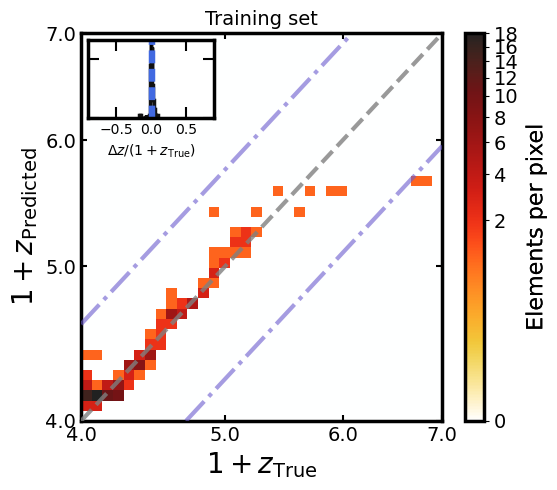

In [112]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(train_prediction_reg.loc[:, 'Z'], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/compare_plot_train_redshift_06.pdf', bbox_inches='tight')
plt.show()

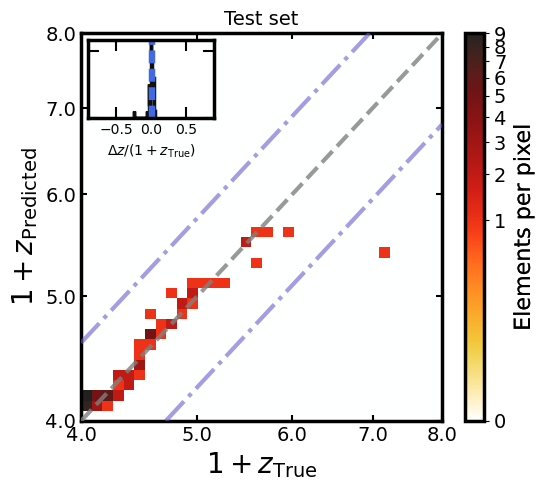

In [113]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(test_prediction_reg.loc[:, 'Z'], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/compare_plot_test_redshift_06.pdf', bbox_inches='tight')
plt.show()

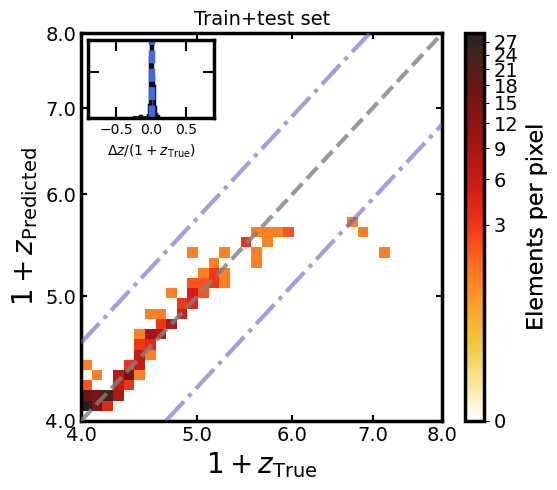

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(train_test_prediction_reg.loc[:, 'Z'], train_test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Train+test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/compare_plot_train_test_redshift_06.pdf', bbox_inches='tight')
plt.show()

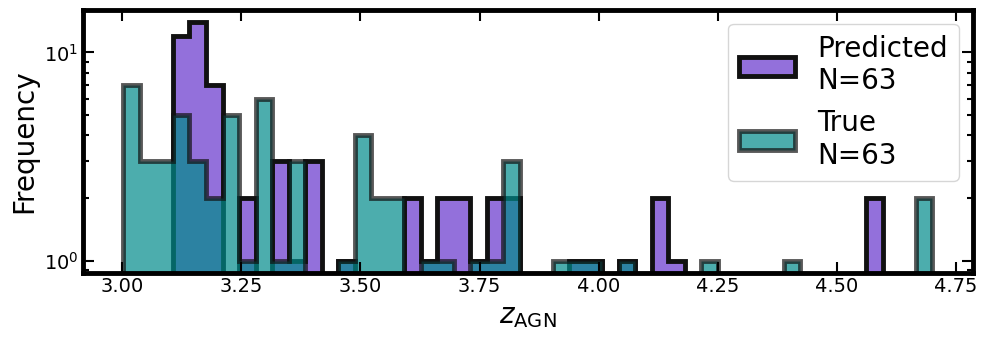

In [115]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/hist_true_predicted_z_05.pdf')
plt.show()